In [30]:
from MN_Custom_Palette import *

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from sklearn.metrics import r2_score

In [31]:
ML_dataset = pd.read_csv("sample_training_dataset.csv")
ML_dataset

,Subject,E,rho,beta,lambda1,Avg S11 t=0,Supersonic Velocity,Rayleigh Velocity,Material Model
0,S1_NH,277852.82340,1149.405018,-1.000000,1.265893,74720.726560,17.067589,10.962885,Neo_Hookean
1,S2_NH,72770.43609,1110.480391,-1.000000,1.307105,22708.906250,8.953453,5.917337,Neo_Hookean
2,S3_NH,115756.53340,1068.204752,-1.000000,1.094942,10969.375980,11.318031,6.252312,Neo_Hookean
3,S4_NH,80938.77378,1159.550661,-1.000000,1.306579,25213.136720,9.234179,6.104142,Neo_Hookean
4,S5_NH,163726.44700,1104.035792,-1.000000,1.219626,36199.480470,13.313761,8.252809,Neo_Hookean
5,S1_MR,50707.74225,1137.429522,-0.547969,1.064675,3225.474854,7.175936,3.855377,Mooney_Rivlin
6,S2_MR,273366.43950,1115.327017,0.844074,1.307968,67143.531250,10.929046,9.994777,Mooney_Rivlin
7,S3_MR,155739.23900,1141.116586,0.058375,1.134303,19618.195310,11.944191,7.067185,Mooney_Rivlin
8,S4_MR,203703.49590,1146.903523,-0.080295,1.294428,54550.210940,13.216232,9.094126,Mooney_Rivlin
9,S5_MR,140465.24450,1090.409049,0.388911,1.096798,12746.599610,11.603165,6.609011,Mooney_Rivlin


# Gaussian Process Emulation

In [53]:
#==================== Data Preparation for Machine Learning ====================#

inputs = ML_dataset[["E", "rho", "beta", "lambda1"]]
outputs = ML_dataset[["Rayleigh Velocity", "Supersonic Velocity"]]


# Reserve 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)


# Rescale inputs for training
PredictorScaler = StandardScaler()
TargetVarScaler = StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(np.array(X_train))
TargetVarScalerFit = TargetVarScaler.fit(np.array(y_train))
 
# Generating the standardized values of X and y
X_train_rescaled = PredictorScalerFit.transform(np.array(X_train))
X_train_rescaled = pd.DataFrame(X_train_rescaled, columns=inputs.columns)

X_test_rescaled = PredictorScalerFit.transform(np.array(X_test))
X_test_rescaled = pd.DataFrame(X_test_rescaled, columns=inputs.columns)

y_train_rescaled = TargetVarScalerFit.transform(np.array(y_train))
y_train_rescaled = pd.DataFrame(y_train_rescaled, columns=["Rayleigh Velocity", "Supersonic Velocity"])

y_test_rescaled = TargetVarScalerFit.transform(np.array(y_test))
y_test_rescaled = pd.DataFrame(y_test_rescaled, columns=["Rayleigh Velocity", "Supersonic Velocity"])

In [54]:
#==================== Machine Learning Model Definitions and Training ====================#

# Define blank slate models
kernel = 1.0 * RBF(1.0) + WhiteKernel()
gpr_model = GaussianProcessRegressor(kernel = kernel, normalize_y=False, random_state = 1)

# Train the models
gpr_model.fit(np.array(X_train_rescaled), np.array(y_train_rescaled))
gpr_model.score(np.array(X_train_rescaled), np.array(y_train_rescaled))

C:\Users\mattn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.9999999998383351

### Note, for completeness the code for visualising model performance has been included however due to the small number of data points in the sample training data set, the results should not be used for inference

In [57]:
#==================== Evaluation of Model Performance ====================#

# Use the trained GP model to predict all values from the sample training dataset

gpr_pred, gpr_pred_std = gpr_model.predict(X_test_rescaled, return_std=True)
gpr_pred_natural = TargetVarScaler.inverse_transform(gpr_pred) # Reversing the scaling to get true predictions
gpr_pred_df = pd.DataFrame(gpr_pred_natural, columns = ["Rayleigh Velocity", "Supersonic Velocity"])

lower_bound = TargetVarScaler.inverse_transform(gpr_pred - 2.58 * gpr_pred_std)
upper_bound = TargetVarScaler.inverse_transform(gpr_pred + 2.58 * gpr_pred_std)
Confidence_Level = 99

C:\Users\mattn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


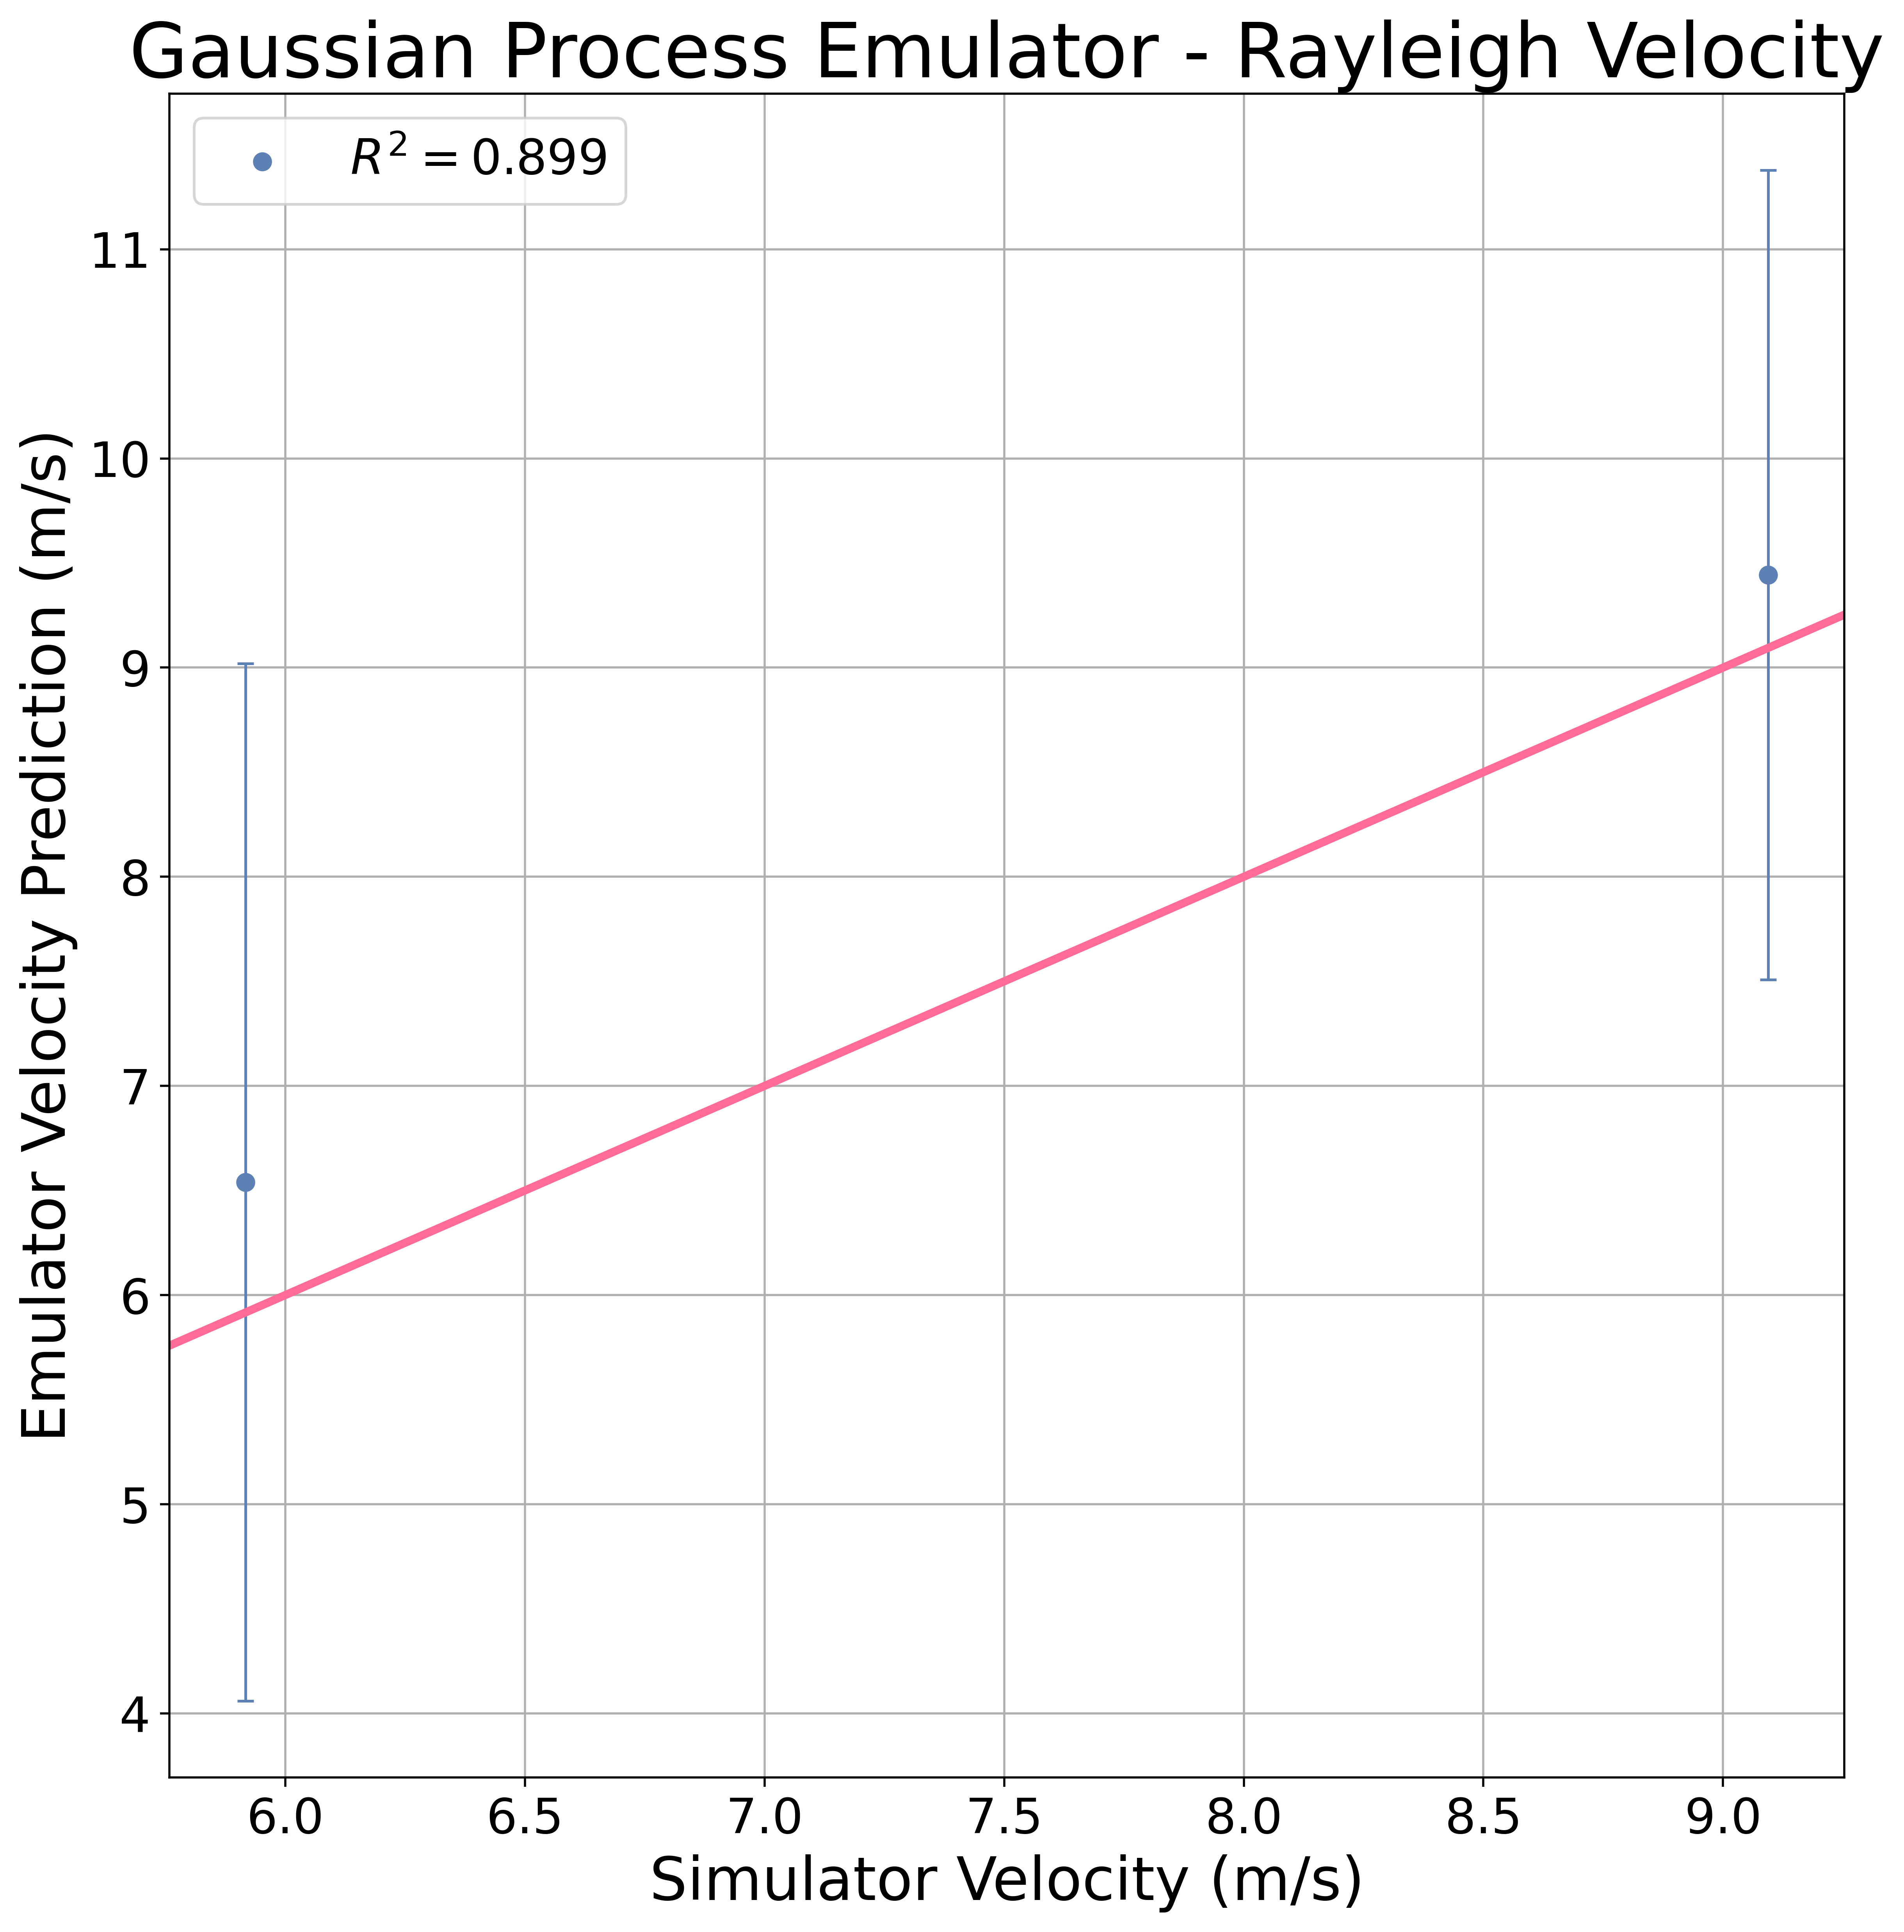

In [58]:
plt.figure(dpi = mn_dpi, figsize=mn_square_fig_size) 

plt.scatter(y_test["Rayleigh Velocity"],
            gpr_pred_df["Rayleigh Velocity"], 
            label="$R^2 = {}$".format(round(r2_score(y_test["Rayleigh Velocity"], 
                                                     gpr_pred_df["Rayleigh Velocity"]),5)), 
            color = mn_colours[0])

plt.errorbar(y_test["Rayleigh Velocity"],
             gpr_pred_df["Rayleigh Velocity"], 
             yerr=upper_bound[:, 0] - gpr_pred_df["Rayleigh Velocity"],
             fmt = "none",
             lw=1, 
             capsize=3, 
             color = mn_colours[0])

plt.axline((min(y_test["Rayleigh Velocity"]), 
            min(y_test["Rayleigh Velocity"])), slope = 1, 
           linewidth = 3, color=mn_colours[3])


plt.title("Gaussian Process Emulator - Rayleigh Velocity", fontsize = mn_title_fontsize)
plt.xlabel("Simulator Velocity (m/s)", fontsize = mn_axis_fontsize)
plt.ylabel("Emulator Velocity Prediction (m/s)", fontsize = mn_axis_fontsize)
plt.xticks(fontsize=mn_ticks_fontsize)
plt.yticks(fontsize=mn_ticks_fontsize)

plt.grid()
plt.tight_layout()
plt.subplots_adjust(right=0.95)
plt.legend(fontsize = mn_legend_fontsize)

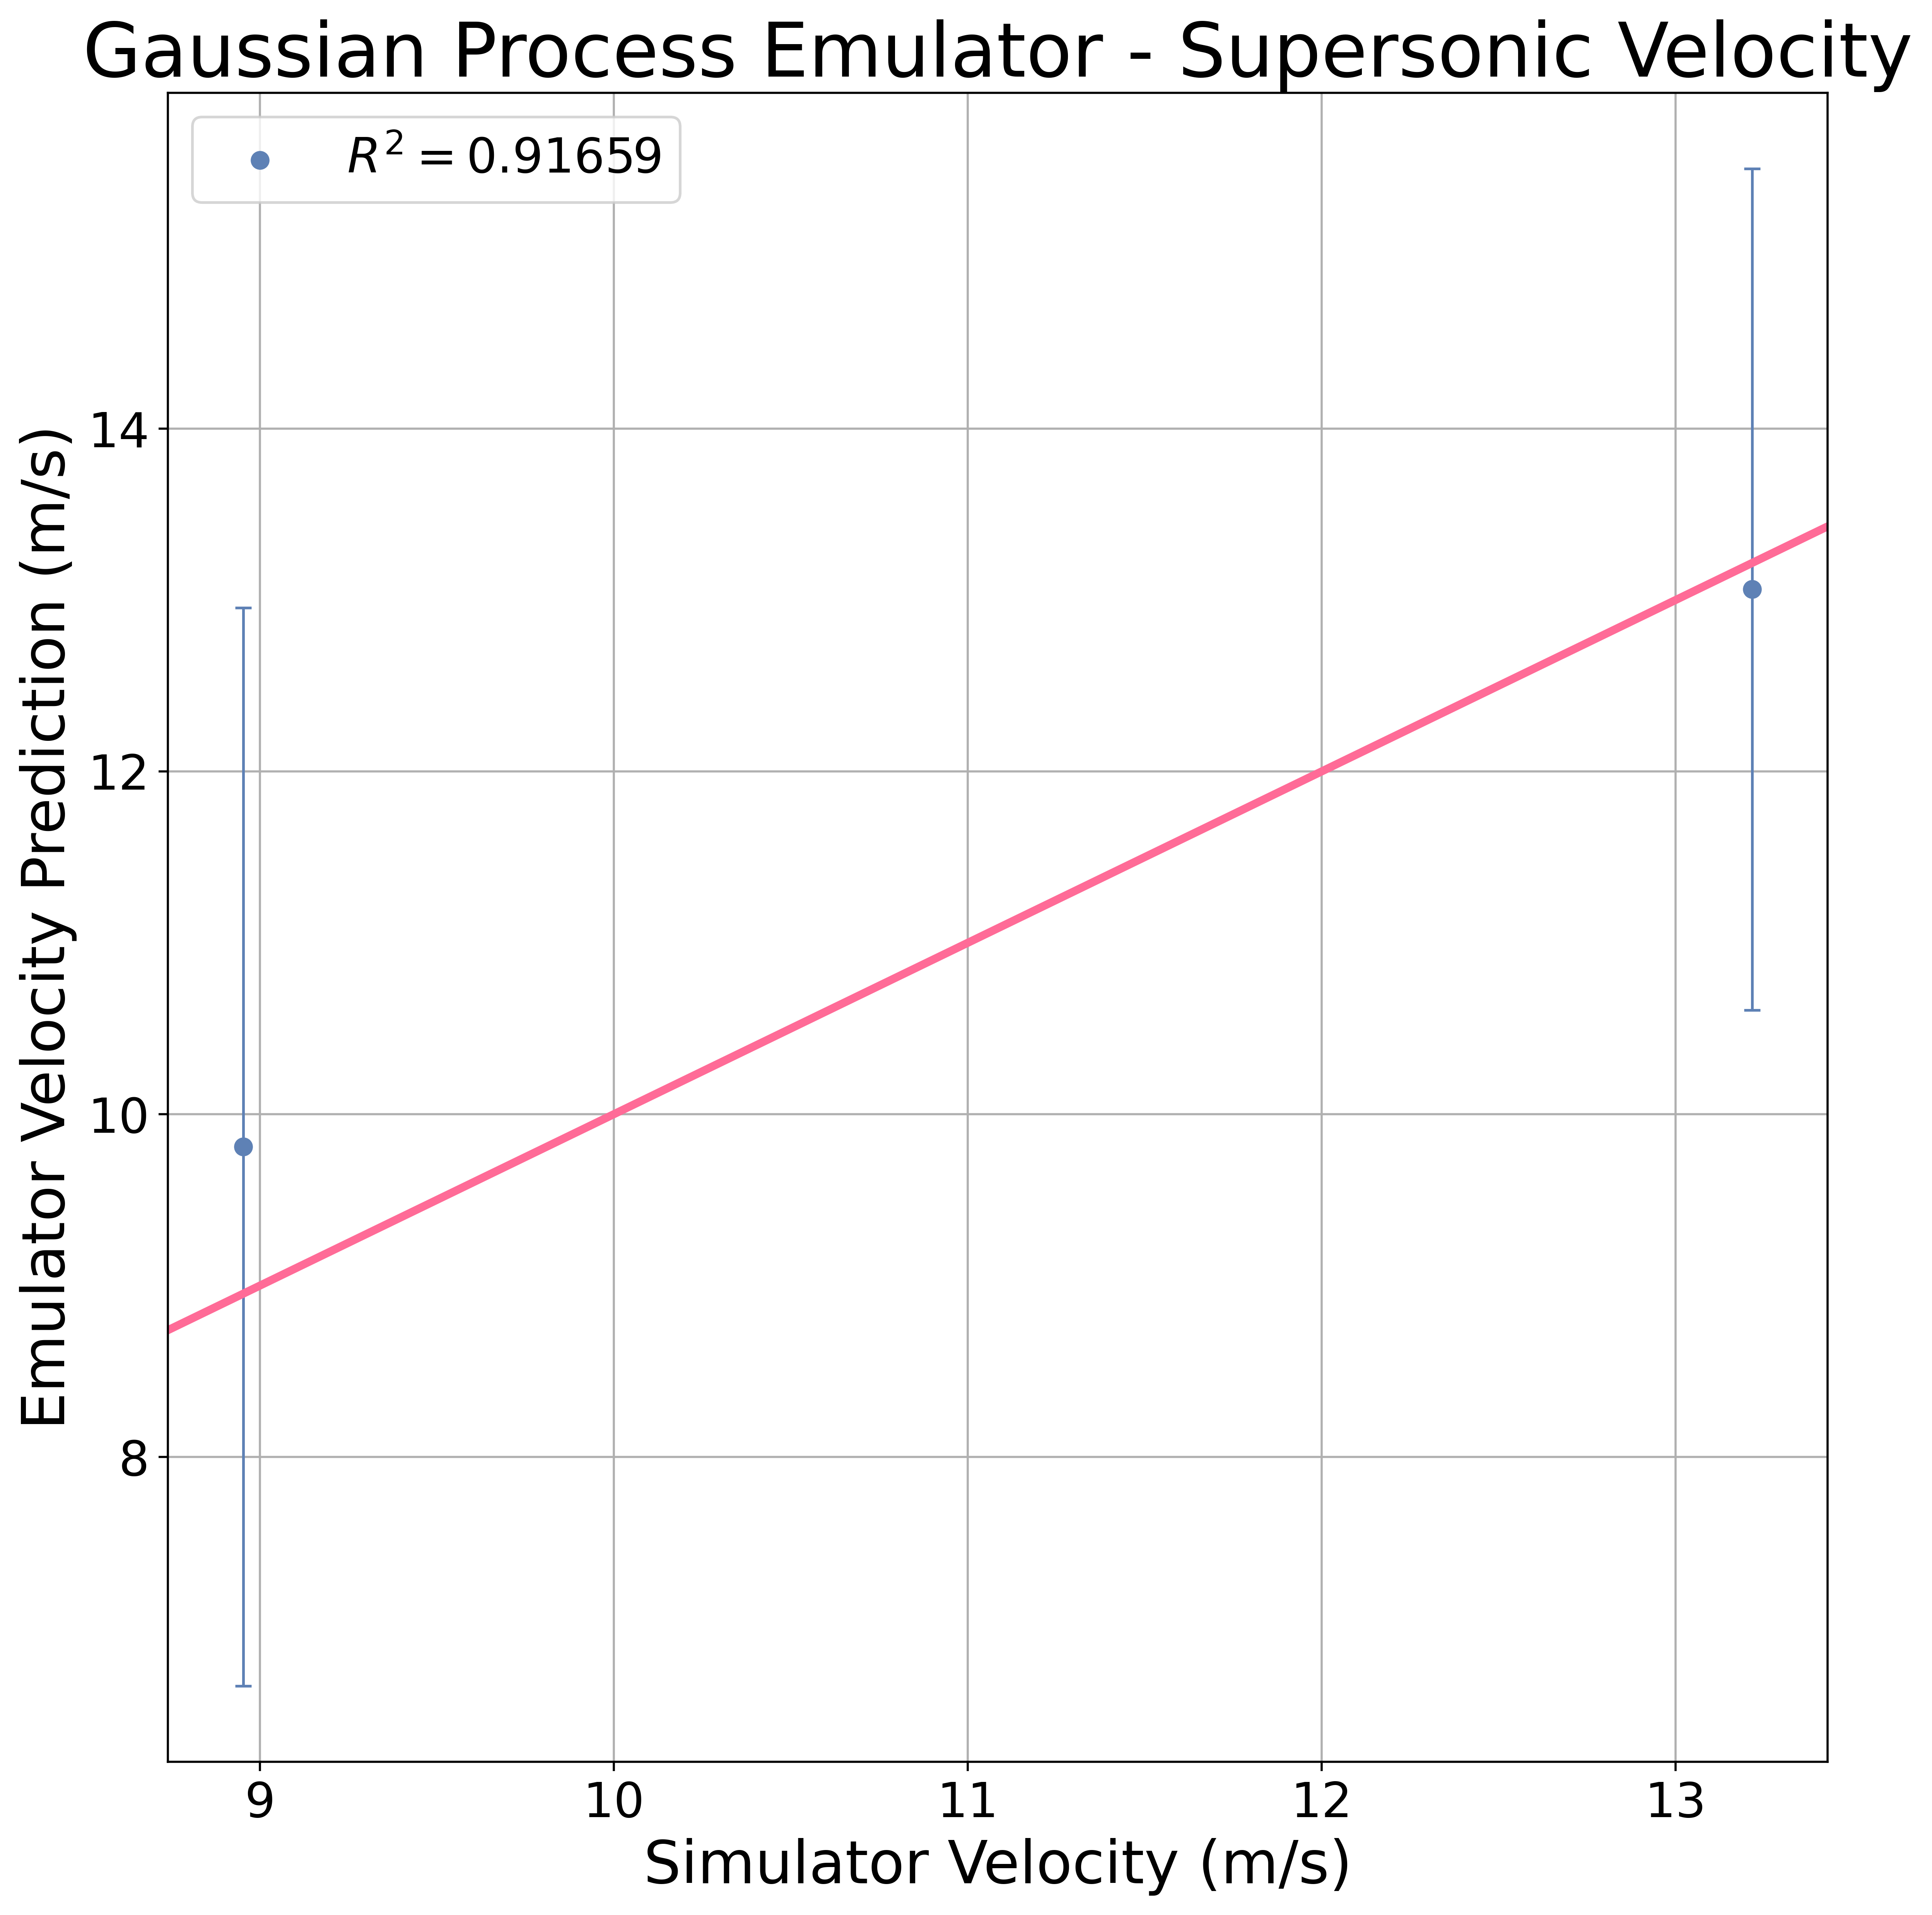

In [59]:
plt.figure(dpi = mn_dpi, figsize=mn_square_fig_size) 

plt.scatter(y_test["Supersonic Velocity"],
            gpr_pred_df["Supersonic Velocity"], 
            label="$R^2 = {}$".format(round(r2_score(y_test["Supersonic Velocity"], 
                                                     gpr_pred_df["Supersonic Velocity"]),5)), 
            color = mn_colours[0])

plt.errorbar(y_test["Supersonic Velocity"],
             gpr_pred_df["Supersonic Velocity"], 
             yerr=upper_bound[:, 1] - gpr_pred_df["Supersonic Velocity"],
             fmt = "none",
             lw=1, 
             capsize=3, 
             color = mn_colours[0])

plt.axline((min(y_test["Supersonic Velocity"]), 
            min(y_test["Supersonic Velocity"])), slope = 1, 
           linewidth = 3, color=mn_colours[3])


plt.title("Gaussian Process Emulator - Supersonic Velocity", fontsize = mn_title_fontsize)
plt.xlabel("Simulator Velocity (m/s)", fontsize = mn_axis_fontsize)
plt.ylabel("Emulator Velocity Prediction (m/s)", fontsize = mn_axis_fontsize)
plt.xticks(fontsize=mn_ticks_fontsize)
plt.yticks(fontsize=mn_ticks_fontsize)

plt.grid()
plt.tight_layout()
plt.subplots_adjust(right=0.95)
plt.legend(fontsize = mn_legend_fontsize)

# Gaussian Process Model to Predict Stress and Pre-Stretch

In [62]:
#==================== Data Preparation for Machine Learning ====================#

inputs = ML_dataset[["Rayleigh Velocity", "Supersonic Velocity"]]
outputs = ML_dataset[["Avg S11 t=0", "lambda1"]]


# Reserve 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)


# Rescale inputs for training
PredictorScaler = StandardScaler()
TargetVarScaler = StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(np.array(X_train))
TargetVarScalerFit = TargetVarScaler.fit(np.array(y_train))
 
# Generating the standardized values of X and y
X_train_rescaled = PredictorScalerFit.transform(np.array(X_train))
X_train_rescaled = pd.DataFrame(X_train_rescaled, columns=inputs.columns)

X_test_rescaled = PredictorScalerFit.transform(np.array(X_test))
X_test_rescaled = pd.DataFrame(X_test_rescaled, columns=inputs.columns)

y_train_rescaled = TargetVarScalerFit.transform(np.array(y_train))
y_train_rescaled = pd.DataFrame(y_train_rescaled, columns=["Avg S11 t=0", "lambda1"])

y_test_rescaled = TargetVarScalerFit.transform(np.array(y_test))
y_test_rescaled = pd.DataFrame(y_test_rescaled, columns=["Avg S11 t=0", "lambda1"])

In [63]:
#==================== Machine Learning Model Definitions and Training ====================#

# Define blank slate models
kernel = 1.0 * RBF(1.0) + WhiteKernel()
gpr_model = GaussianProcessRegressor(kernel = kernel, normalize_y=False, random_state = 1)

# Train the models
gpr_model.fit(np.array(X_train_rescaled), np.array(y_train_rescaled))
gpr_model.score(np.array(X_train_rescaled), np.array(y_train_rescaled))

C:\Users\mattn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.999999998756989

### Again, for completeness the code for visualising model performance has been included however due to the small number of data points in the sample training data set, the results should not be used for inference

In [64]:
#==================== Evaluation of Model Performance ====================#

# Use the trained GP model to predict values for the test set

gpr_pred, gpr_pred_std = gpr_model.predict(X_test_rescaled, return_std=True)
gpr_pred_natural = TargetVarScaler.inverse_transform(gpr_pred) # Reversing the scaling to get true predictions
gpr_pred_df = pd.DataFrame(gpr_pred_natural, columns = ["Rayleigh Velocity", "Supersonic Velocity"])

lower_bound = TargetVarScaler.inverse_transform(gpr_pred - 2.58 * gpr_pred_std)
upper_bound = TargetVarScaler.inverse_transform(gpr_pred + 2.58 * gpr_pred_std)
Confidence_Level = 99

C:\Users\mattn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianProcessRegressor was fitted without feature names
  warnings.warn(


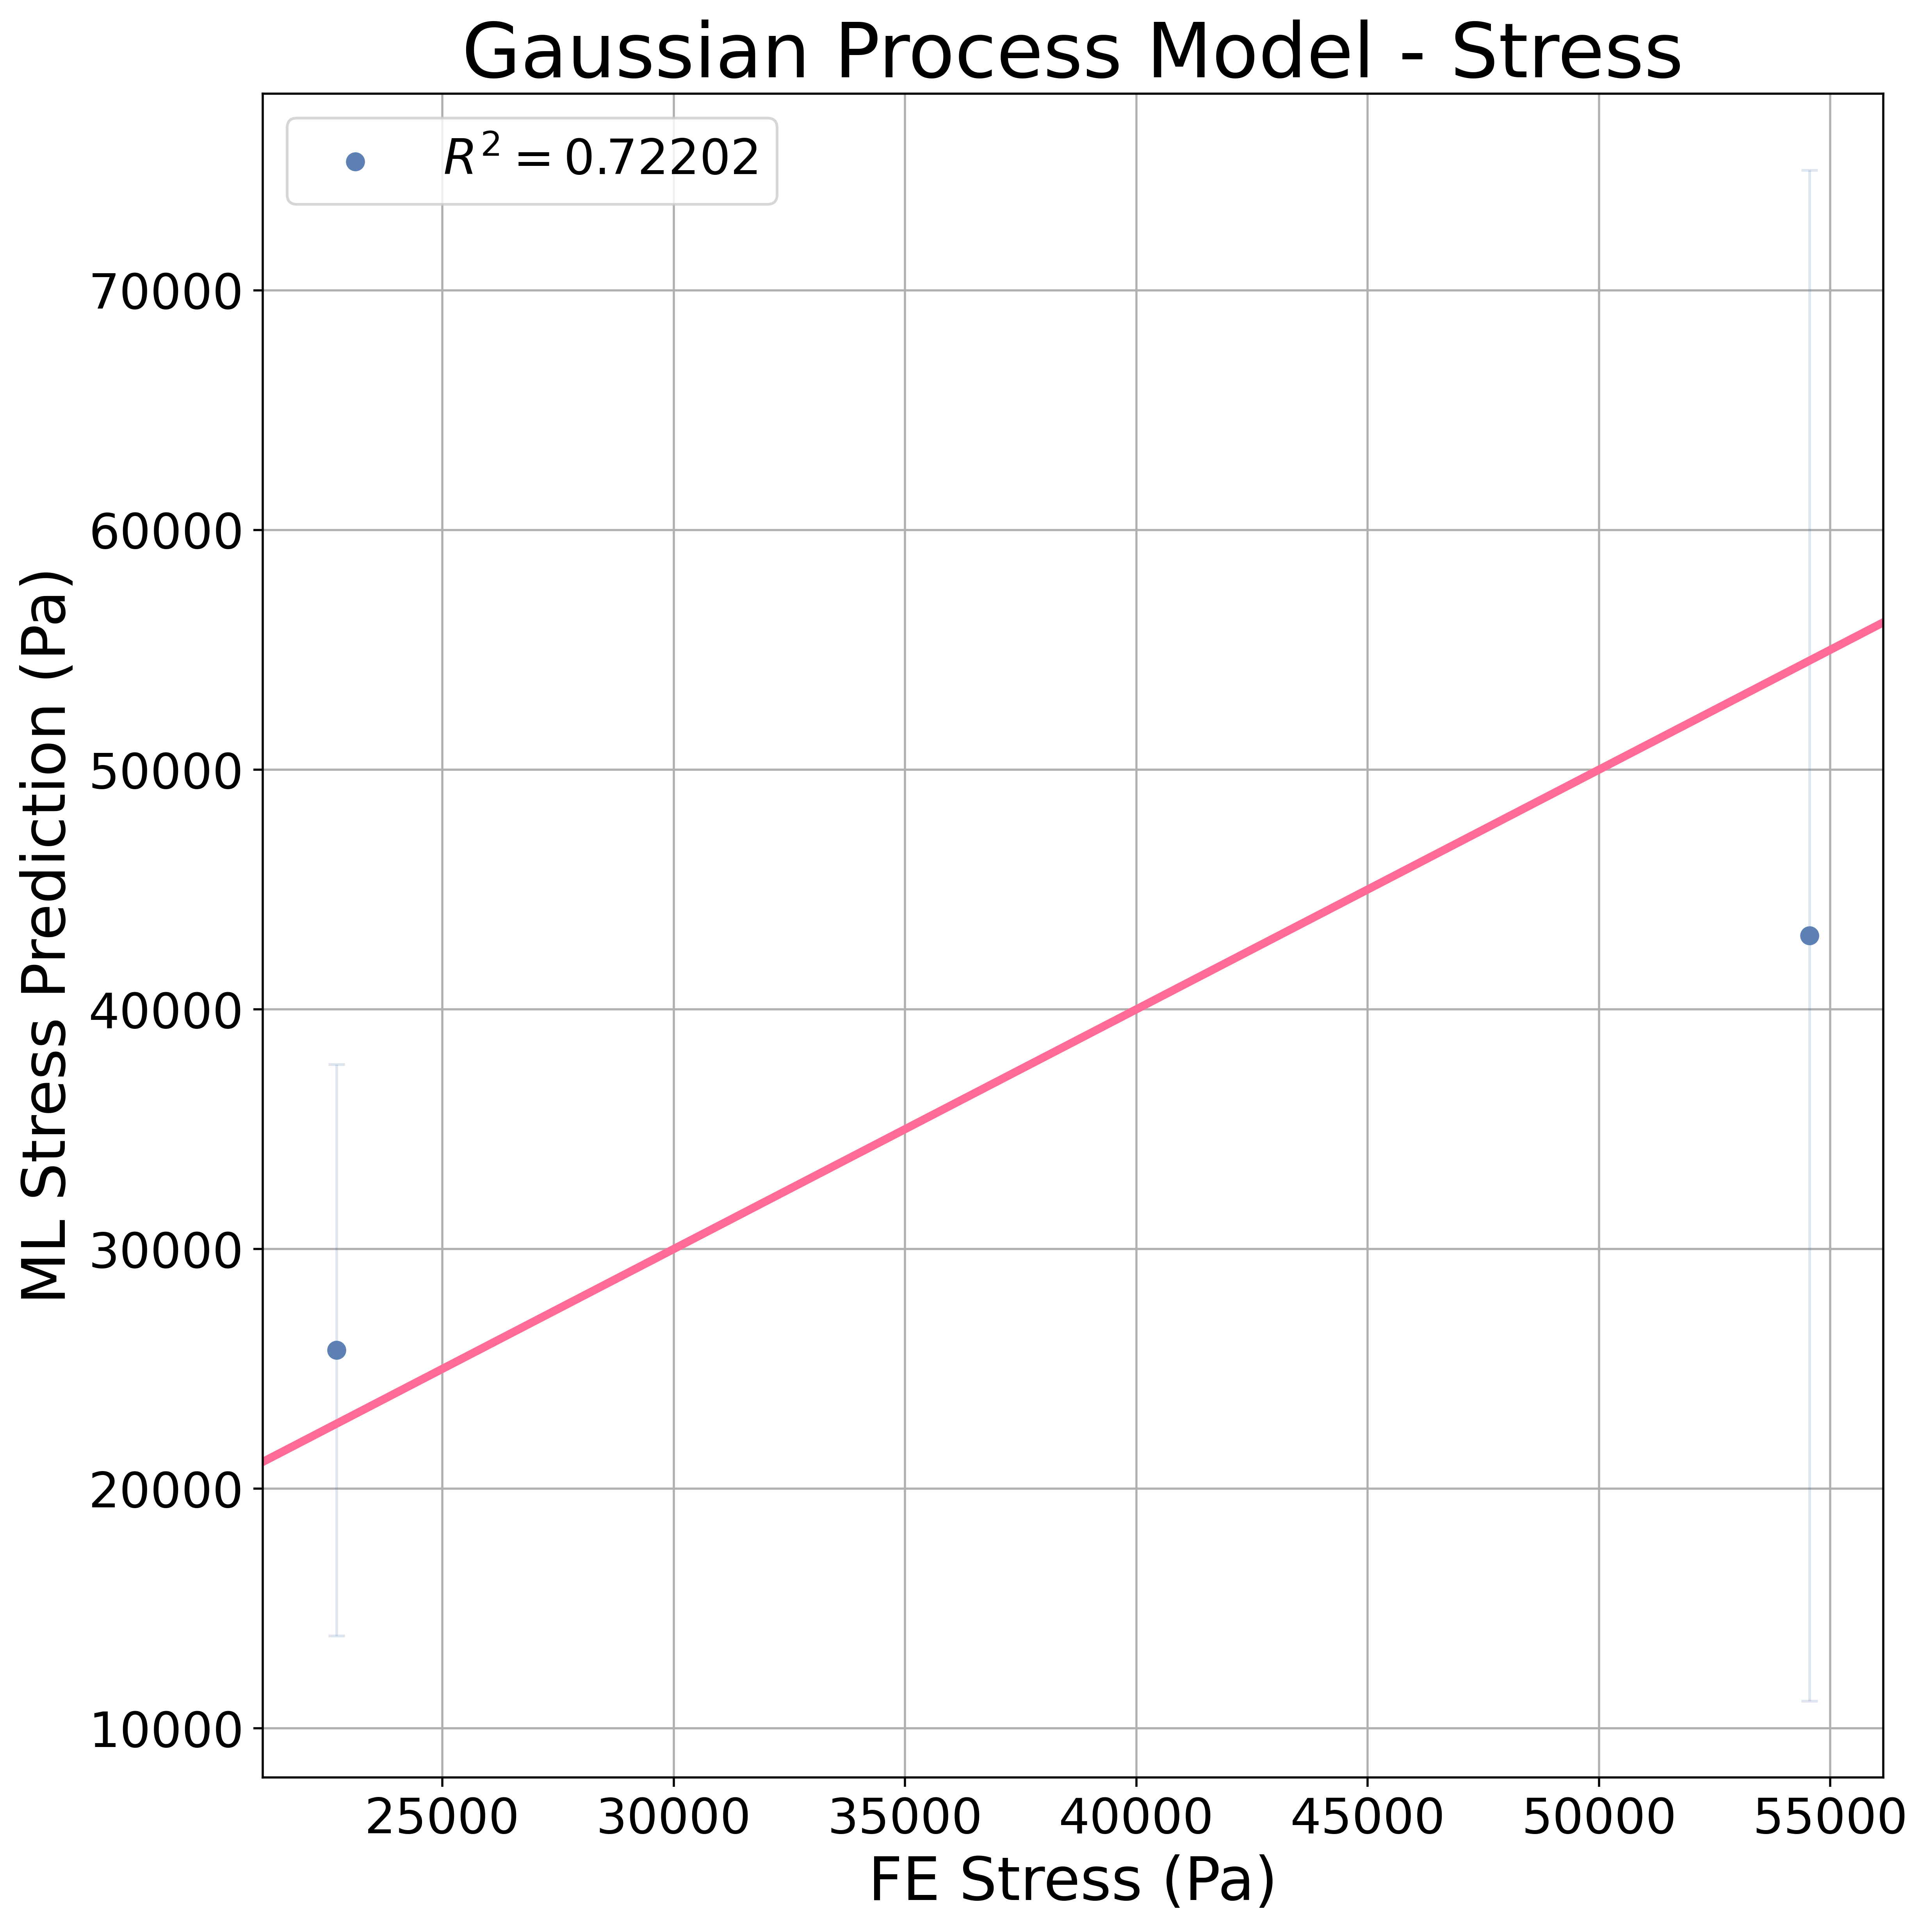

In [66]:
plt.figure(dpi = mn_dpi, figsize=mn_square_fig_size) 

plt.errorbar(y_test["Avg S11 t=0"], 
             gpr_pred_df["Avg S11 t=0"], 
             yerr=upper_bound[:, 0] - gpr_pred_df["Avg S11 t=0"],
             fmt = "none",
             lw=1,
             alpha = 0.2,
             capsize=3, 
             color = mn_colours[0])

plt.scatter(y_test["Avg S11 t=0"], 
            gpr_pred_df["Avg S11 t=0"], 
            label="$R^2 = {}$".format(round(r2_score(y_test["Avg S11 t=0"], 
                                                     gpr_pred_df["Avg S11 t=0"]),5)), 
            color = mn_colours[0])

plt.axline((min(y_test["Avg S11 t=0"]), 
            min(y_test["Avg S11 t=0"])), slope = 1, color=mn_colours[3], linewidth=3)


plt.subplots_adjust(left=0.15)

plt.title("Gaussian Process Model - Stress", fontsize = mn_title_fontsize)
plt.xlabel("FE Stress (Pa)", fontsize = mn_axis_fontsize)
plt.ylabel("ML Stress Prediction (Pa)", fontsize = mn_axis_fontsize)
plt.xticks(fontsize=mn_ticks_fontsize)
plt.yticks(fontsize=mn_ticks_fontsize)

plt.grid()
plt.tight_layout()
plt.legend(fontsize = mn_legend_fontsize)

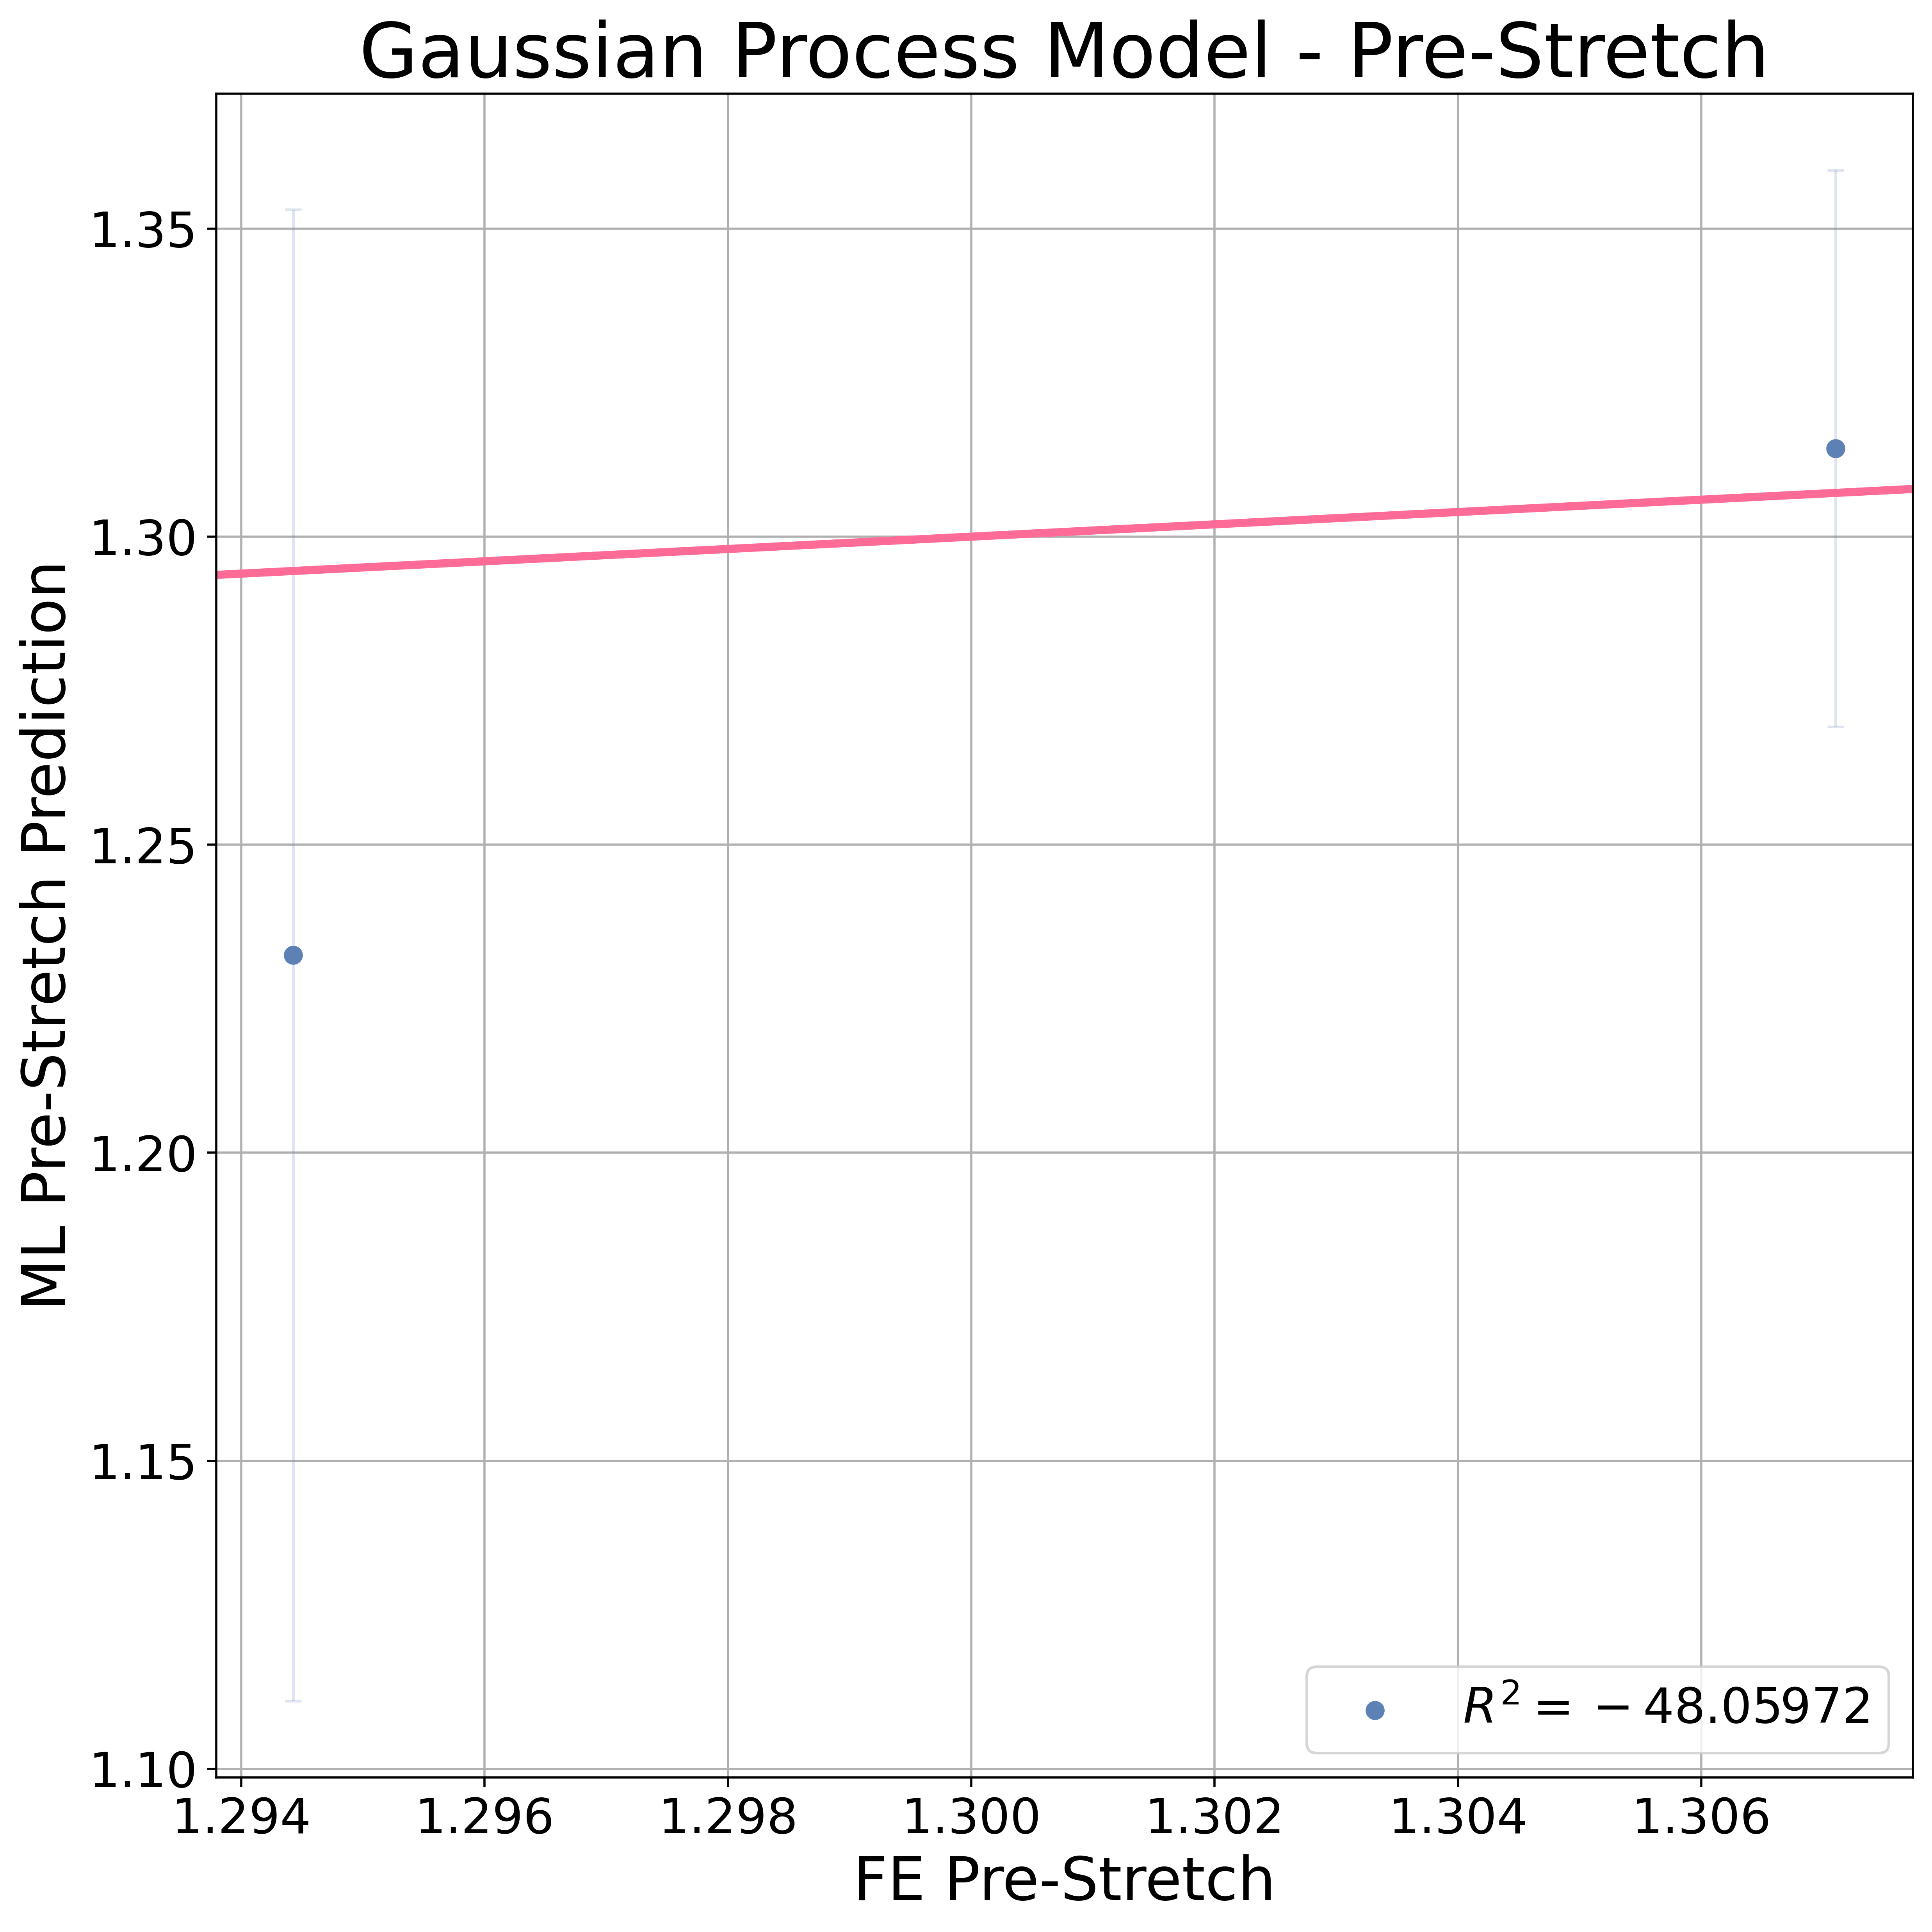

In [67]:
plt.figure(dpi = mn_dpi, figsize=mn_square_fig_size) 

plt.errorbar(y_test["lambda1"],
             gpr_pred_df["lambda1"], 
             yerr=upper_bound[:, 1] - gpr_pred_df["lambda1"],
             fmt = "none",
             lw=1, 
             alpha = 0.2,
             capsize=3, 
             color = mn_colours[0])


plt.scatter(y_test["lambda1"], 
            gpr_pred_df["lambda1"], 
            label="$R^2 = {}$".format(round(r2_score(y_test["lambda1"], 
                                                     gpr_pred_df["lambda1"]),5)), 
            color = mn_colours[0])



plt.axline((min(y_test["lambda1"]), 
            min(y_test["lambda1"])), slope = 1, color=mn_colours[3], linewidth = 3)


plt.subplots_adjust(left=0.15)

plt.title("Gaussian Process Model - Pre-Stretch", fontsize = mn_title_fontsize)
plt.xlabel("FE Pre-Stretch", fontsize = mn_axis_fontsize)
plt.ylabel("ML Pre-Stretch Prediction", fontsize = mn_axis_fontsize)
plt.xticks(fontsize=mn_ticks_fontsize)
plt.yticks(fontsize=mn_ticks_fontsize)

plt.grid()
plt.tight_layout()
plt.legend(fontsize = mn_legend_fontsize)